<a href="https://colab.research.google.com/github/kentokura/python_medical_images/blob/master/chapter3/chap3_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
from google.colab import drive
from IPython.display import Image, display_png

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 3.10 画像と周波数(２次元フーリエ変換)


リスト 3.10.1

In [3]:
import plotly.express as px

pix = cv2.imread('/content/drive/My Drive/DATASET/dataset/ChestXray256_uint8.png',
                 cv2.IMREAD_GRAYSCALE)

pix_line = cv2.rectangle(np.copy(pix), (0, 128-1), (256, 128-1), (0, 255, 0), 3)
fig = px.imshow(pix_line, color_continuous_scale='gray') # plotlyで描画
fig.show()

c_row = pix[128-1, :]
data = {'intensity': c_row,
        'col': np.linspace(0, 255, 256)
        }
df = pd.DataFrame(data=data)
print(df.head())
fig = px.line(df, x='col', y='intensity', title='pixel intensities at row128')
fig.show()

   intensity  col
0        240  0.0
1        239  1.0
2        237  2.0
3        237  3.0
4        236  4.0


リスト 3.10.2

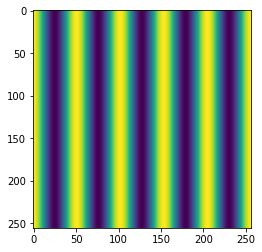

In [4]:
from scipy .fft import idct
#縞のある画像を作成
a=np.zeros((256,256)) #任意の正方形に
a[0,10]=1
base=idct(idct(a,axis=0),axis=1) #周期性のある2次元配列を離散コサイン変換で求める
plt.imshow(base)  #idct→離散コサイン変換
plt.show()

#中央の行を取得しライングラフへ
row128=base[128-1,:]
data={'intensity':row128,"col":np.linspace(0,255,256)}
df=pd.DataFrame(data=data)
fig=px.line(df,x="col",y="intensity",title='pixel intensities at row128')
fig.show()

リスト 3.10.3

In [5]:
from numpy.fft import fft
#リスト3.10.1胸部の行データを使用する
x=c_row
#フーリエ変換を実施
freq=fft(x)
#結果を絶対値で取得(結果が複素数で返ってくるため)
freq_abs=np.abs(freq) #fft result
'''
グラフにして、左右のシンメトリーになることを確認
ナイキスト周波数の位置(N/2)以降が虚像(pretense)
特殊な操作であるが、虚像をわかりやすくするために配列の前半と後半を入れ替える
'''
swap=np.zeros(256)
swap[:128]=freq_abs[128:256]
swap[128]=freq_abs[0]
swap[129:]=freq_abs[1:128]
#グラフ用のデータへ
data={'freq':swap,"size":np.linspace(0,255,256)}
df=pd.DataFrame(data=data)
#シンメトリーをグラフへ
fig=px.line(df,x="size",y='freq',title="fft result with the pretense at row128")
fig.show()
'''
実際の計算にはナイキスト周波数の位置(N/2)以降の虚像部分は不要
ナイキスト周波数の位置(N/2)までをグラフへ
この例ではN=256のため、その位置は128
'''
data={"freq":freq_abs[0:128],'size':np.linspace(0,128,128)}
df=pd.DataFrame(data=data)
fig=px.line(df,x="size",y='freq',title="fft result with the pretense at row128")
fig.show()

リスト 3.10.4 1次元フーリエ変換結果を3Dグラフで確認

In [6]:
# 胸部の128秒目のピクセル配列を利用
x = c_row
# ないキスと周波数までを取得,それ以降は虚像のため不要
freq = fft(x)[0:128]
freq_max = np.max(np.abs(freq))

N = len(freq) # データ数
n = np.arange(N) # 1刻みの配列をN個

# 各周波数をsin波の信号に変換
wave_arr = []
name_arr = []
location_arr = []
for i in range(N):
  norm = np.abs(freq[i] / freq_max) # 正規化
  freq_sin_wave = np.sin(np.abs(freq[i]) * 2 * np.pi * (n/N)) * norm
  name = ['freq' + str(i)] * N
  if i < 16 : #16番目までの低周波成分を可視化
    wave_arr.extend(freq_sin_wave)
    name_arr.extend(name)
    location_arr.extend(n)

# グラフデータへ
data = {'amplitude' : wave_arr,
        'sampling location': location_arr,
        'freq': name_arr,
        }
df = pd.DataFrame(data=data)
fig = px.line_3d(df, x = "sampling location", y = "freq",
                 z = "amplitude", color = "freq")
fig.show()

### 3.10.3 2次元フーリエ変換

リスト3.10.5 2次元フーリエ変換

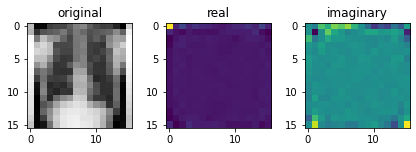

In [22]:
import cv2
import numpy as np
from numpy.fft import *
import matplotlib.pyplot as plt

H = 16
W = 16

chest = cv2.imread(
    '/content/drive/My Drive/DATASET/dataset/ChestXray256_uint8.png', 
    cv2.IMREAD_GRAYSCALE).astype(float)
# ダウンサンプル
chest = cv2.resize(chest, (W, H), cv2.INTER_LANCZOS4)
plt.subplot(131)
plt.title("original")
plt.tight_layout()
plt.imshow(chest, cmap="gray")

spectrum = np.fft.fft2(chest)
spectrum = np.fft.fftshift(spectrum) # swap
real = np.real(spectrum)
imag = np.imag(spectrum)

plt.subplot(132)
plt.tight_layout()
plt.imshow(real) #, cmap="gray")
plt.title("real")

plt.subplot(133)
plt.tight_layout()
plt.imshow(imag) #, cmap="gray")
plt.title("imaginary")
plt.show()